<h1 style="font-weight: 700">Nelder-Mead Method applied to Sigal Recovery</h1>
<p style="font-style: italic">by Nicolas Fagundes Ouverney</p>

<h4 name="dependences" style="font-weight: 700">Libraries & Functions Definitions</h4>

In [14]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# FUNCTIONS
# Nelder-Mead Method Algorithm
def Nelder_Mead_Method(f, init_point, max_iter, tol_absValue, tol_interval):
    n = len(init_point) # number of dimensions of the function f
    # Adaptive Nelder-Mead Simplex
    alpha = 1 # reflection coefficient
    gamma = 1 + 2/n # expansion coefficient
    rho = 0.75 - 1/(2*n) # contraction coefficient
    sigma = 1 - 1/n # shrink coefficient

    # defines points for a initial simplex
    simplex = [init_point]    
    for i in range(0, n):
        aux_init_simplex = init_point[:]
        for j in range(0, n):
            if i == j:
                aux_init_simplex[i] += 0.05
        simplex.append(np.array(aux_init_simplex))
    
    # preparation for the loop
    k = 0
    while k < max_iter or max_iter == -1:
        simplex.sort(key = lambda x: f(x))
        best_value = f(simplex[0])
        worst_value = f(simplex[-1])

        # check the objetive function value and the interval
        if abs(best_value) < tol_absValue and np.mean(simplex[0] - simplex[-1]) < tol_interval:
            break
        
        k += 1
        centroid = np.mean(simplex[:-1], axis = 0) # axis = 0 for efetuate the mean along the column
        
        # calculates reflection point
        reflected_point = centroid + alpha * (centroid - simplex[-1])
        reflected_value = f(reflected_point)

        # reflection
        if reflected_value >= best_value and reflected_value < f(simplex[-2]):
            simplex[-1] = reflected_point[:]
        
        # expansion
        elif reflected_value < best_value:
            expansion_point = centroid + gamma * (reflected_point - centroid)
            expansion_value = f(expansion_point)

            if expansion_value < reflected_value:
                simplex[-1] = expansion_point[:]
            else:
                simplex[-1] = reflected_point[:]
        
        # contraction
        else:
            if reflected_value < worst_value:
                contracted_point = centroid + rho * (reflected_point - centroid)

                if f(contracted_point) < reflected_value:
                    simplex[-1] = contracted_point[:]
                # shrink
                else:
                    for j in range(1, n + 1):
                        simplex[j] = simplex[0] + sigma * (simplex[j] - simplex[0])
            else:
                contracted_point = centroid + rho * (simplex[-1] - centroid)
                if f(contracted_point) < worst_value:
                    simplex[-1] = contracted_point[:]
                # shrink
                else:
                    for j in range(1, n + 1):
                        simplex[j] = simplex[0] + sigma * (simplex[j] - simplex[0])
    
    simplex.sort(key = lambda x: f(x))

    return simplex[0], k

# Objective Function - Root Mean-Square Error
def objective_function(A):
    signal_pattern = np.array([
        A[0]*1.0    + A[1]*0.4524   + A[2]*0.0172   + 0             + 0             + 0             + 0,
        A[0]*0.5633 + A[1]*1        + A[2]*0.4524   + A[3]*0.0172   + 0             + 0             + 0,
        A[0]*0.1493 + A[1]*0.5633   + A[2]*1        + A[3]*0.4524   + A[4]*0.0172   + 0             + 0,
        A[0]*0.0424 + A[1]*0.1493   + A[2]*0.5633   + A[3]*1        + A[4]*0.4524   + A[5]*0.0172   + 0,
        0           + A[1]*0.0424   + A[2]*0.1493   + A[3]*0.5633   + A[4]*1        + A[5]*0.4524   + A[6]*0.0172,
        0           + 0             + A[2]*0.0424   + A[3]*0.1493   + A[4]*0.5633   + A[5]*1        + A[6]*0.4524,
        0           + 0             + 0             + A[3]*0.0424   + A[4]*0.1493   + A[5]*0.5633   + A[6]*1
        ])
    aux_sum = signal - signal_pattern
    return (sum(aux_sum**2) / len(signal))**0.5

<h4 name="inputs-execution" style="font-weight: 700">Inputs & Algorithm Execution</h4>

In [15]:
# DATABASE
file_path = './database/db-pileup.csv'
database = pd.read_csv(file_path).values

# ALGORITHM INPUTS
# stopping criteria
max_iterations = 50000 # put -1 to ignore
tolerance_absvalue = 1e-10 # this tolerance is calculated by the absolute value of the objective function
tolerance_interval = 1e-10 # this tolerance is calculated by the mean between the best point and the worst point of the simplex

# initial simplex
initial_guess = [1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [16]:
# ALGOTITHM EXECUTION
# Lists to store the results
mean_residuals = list()
all_residuals = list()
best_points = list()
real_amplitudes = list()
sum_iterations = 0

# Execution
for i in range(0, int(len(database)), 8):
    # Reading the pileup row from database of the respective iteration
    signal = database[i + 7, 2 :]

    # Calling the Nelder-Mead Method Algorithm
    final_point, num_iter = Nelder_Mead_Method(objective_function, initial_guess, max_iterations, tolerance_absvalue, tolerance_interval)

    # Storing the results
    best_points.append(final_point)
    sum_iterations += num_iter
    amplitudes = list(map(np.longdouble, database[i : i + 7, 1]))
    real_amplitudes.append(amplitudes)
    all_residuals.append(amplitudes - final_point)
    mean_residuals.append(np.mean(amplitudes - final_point))

    # Display the progress every one-hundred signals
    if len(best_points) % 100 == 0:
        print('Progress: {}/{}'.format(len(best_points), len(database)//8))
average_iterations = sum_iterations / len(best_points)

Progress: 100/10000
Progress: 200/10000
Progress: 300/10000
Progress: 400/10000
Progress: 500/10000
Progress: 600/10000
Progress: 700/10000
Progress: 800/10000
Progress: 900/10000
Progress: 1000/10000
Progress: 1100/10000
Progress: 1200/10000
Progress: 1300/10000
Progress: 1400/10000
Progress: 1500/10000
Progress: 1600/10000
Progress: 1700/10000
Progress: 1800/10000
Progress: 1900/10000
Progress: 2000/10000
Progress: 2100/10000
Progress: 2200/10000
Progress: 2300/10000
Progress: 2400/10000
Progress: 2500/10000
Progress: 2600/10000
Progress: 2700/10000
Progress: 2800/10000
Progress: 2900/10000
Progress: 3000/10000
Progress: 3100/10000
Progress: 3200/10000
Progress: 3300/10000
Progress: 3400/10000
Progress: 3500/10000
Progress: 3600/10000
Progress: 3700/10000
Progress: 3800/10000
Progress: 3900/10000
Progress: 4000/10000
Progress: 4100/10000
Progress: 4200/10000
Progress: 4300/10000
Progress: 4400/10000
Progress: 4500/10000
Progress: 4600/10000
Progress: 4700/10000
Progress: 4800/10000
P

<h4 name="results" style="font-weight: 700">Results</h4>

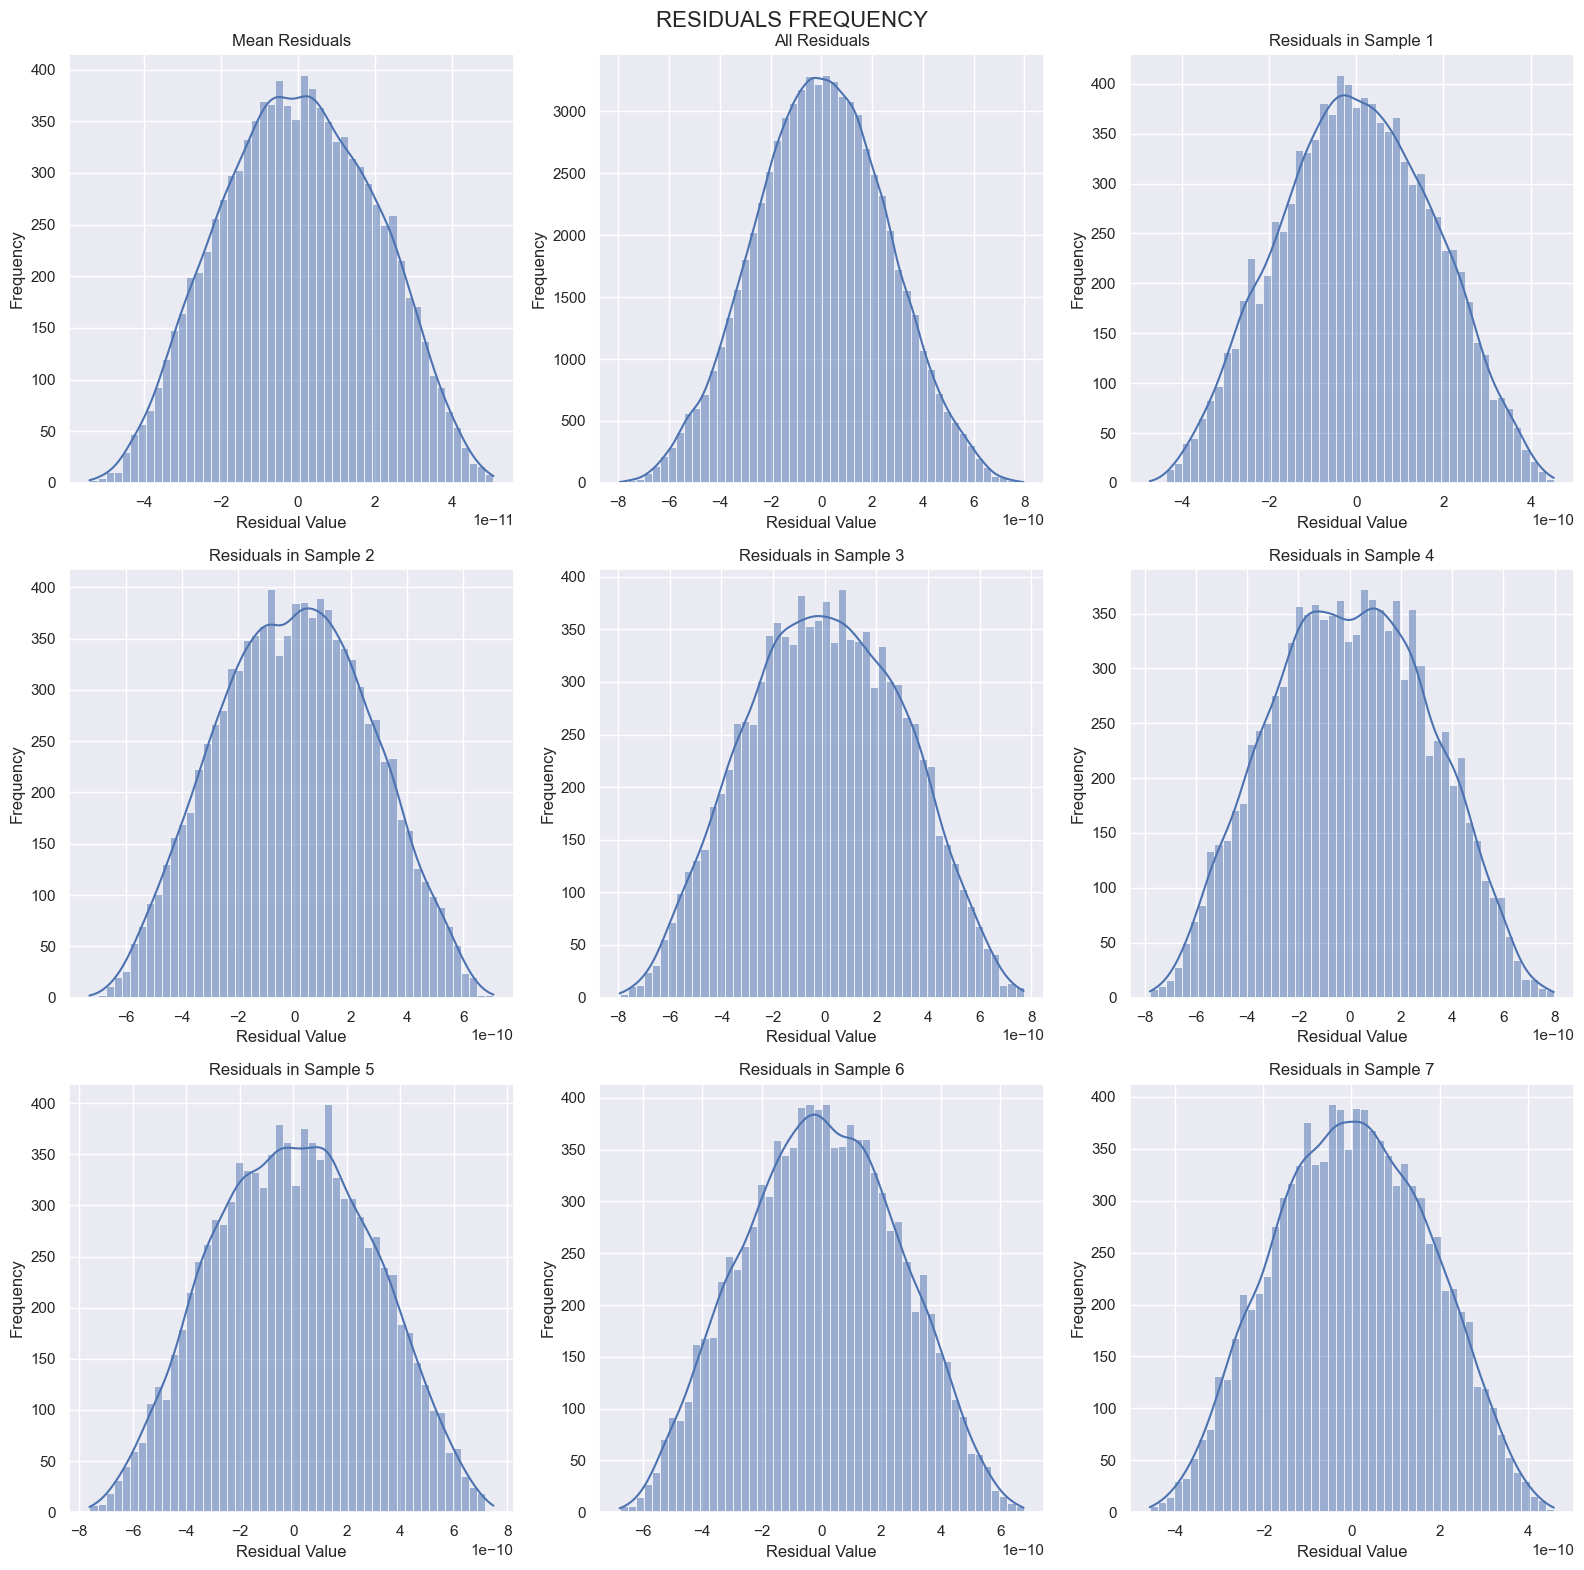

Mean Residuals:


0
0     6.496391e-12
1    -5.409768e-12
2    -3.490998e-11
3     1.438951e-11
4    -3.512111e-11
...            ...
9995 -3.097966e-12
9996 -3.616663e-12
9997  2.512479e-11
9998  5.359522e-12
9999  1.234873e-11

[10000 rows x 1 columns]

Average of Iterations:
2074.9665
AMPLITUDES (CALCULATED & REAL)
Before pile_up_1:
[np.float64(728.8166117265669), np.float64(455.86865741801734), np.float64(201.09979330645714), np.float64(988.8318163136281), np.float64(306.13495407853907), np.float64(603.9369159720552), np.float64(857.0404813915516)]
[np.longdouble('728.8166117266045'), np.longdouble('455.86865741796976'), np.longdouble('201.09979330626803'), np.longdouble('988.8318163139403'), np.longdouble('306.13495407833136'), np.longdouble('603.9369159722419'), np.longdouble('857.040481391505')] 

Before pile_up_2:
[np.float64(506.51613377142854), np.float64(638.7700710750429), np.float64(933.5694332956791), np.float64(210.12877456060963), np.float64(393.45922515661886), np.float64(28.937927863440827), np.float64(484.9812097934303)]
[np.longdouble('506.5161337714142'), np.longdouble('638.7700710751817'), np.longdouble('933.5694332955053'), np.longdouble('210.1287745606496'), np.longdouble('393.45922515670384'), np.longdouble('28.

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 16), tight_layout = True)

mean_residuals = pd.DataFrame(mean_residuals)
aux_residuals = list()
for k in range(0, len(all_residuals)):
    for l in range(0, len(all_residuals[0])):
        aux_residuals.append(all_residuals[k][l])
aux_residuals = pd.DataFrame(aux_residuals)

plt.suptitle("RESIDUALS FREQUENCY", fontsize = 16)
sns.set_theme(style = "darkgrid")
count = 0
for i in range(0, 3):
    for j in range(0, 3):
        if i == 0 and j == 0:
            sns.histplot(data = mean_residuals, bins = 50, ax = ax[i, j], kde = True, legend = False)
            ax[i, j].set_title('Mean Residuals')
            ax[i, j].set_xlabel('Residual Value')
            ax[i, j].set_ylabel('Frequency')
        elif i == 0 and j == 1:
            sns.histplot(data = aux_residuals, bins = 50, ax = ax[i, j], kde = True, legend = False)
            ax[i, j].set_title('All Residuals')
            ax[i, j].set_xlabel('Residual Value')
            ax[i, j].set_ylabel('Frequency')
        else:
            by_time = aux_residuals[count::7]
            count += 1
            sns.histplot(data = by_time, bins = 50, ax = ax[i, j], kde = True, legend = False)
            ax[i, j].set_title(f'Residuals in Sample {count}')
            ax[i, j].set_xlabel('Residual Value')
            ax[i, j].set_ylabel('Frequency')
plt.show()

# Other information
print('Mean Residuals:')
display(mean_residuals)
print('Average of Iterations:')
print(average_iterations)
print('AMPLITUDES (CALCULATED & REAL)')
for i in range(0, len(best_points)):
    print('Before pile_up_{}:'.format(i + 1))
    print(list(best_points[i]))
    print(list(real_amplitudes[i]),'\n')